# Data Analytics Exercise
The data set examined comes from Keggle (https://www.kaggle.com/datasets/mohamedharris/supermart-grocery-sales-retail-analytics-dataset).
It is a fictional data set containing orders from customers of a food delivery app.

The goal of this analysis is to obtain an overview of popular categories or subcategories.
Perhaps interesting correlations between categories and profits can be identified. 

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
path = kagglehub.dataset_download("mohamedharris/supermart-grocery-sales-retail-analytics-dataset")

df = pd.read_csv(path + "/Supermart Grocery Sales - Retail Analytics Dataset.csv")

First, we will get an overview of the data.

In [3]:
df.head()

,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State
0,OD1,Harish,Oil & Masala,Masalas,Vellore,11-08-2017,North,1254,0.12,401.28,Tamil Nadu
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,11-08-2017,South,749,0.18,149.80,Tamil Nadu
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,06-12-2017,West,2360,0.21,165.20,Tamil Nadu
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,10-11-2016,South,896,0.25,89.60,Tamil Nadu
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,10-11-2016,South,2355,0.26,918.45,Tamil Nadu


In [4]:
df.isnull().sum()

Order ID         0
Customer Name    0
Category         0
Sub Category     0
City             0
Order Date       0
Region           0
Sales            0
Discount         0
Profit           0
State            0
dtype: int64

In [5]:
df.duplicated().sum()

np.int64(0)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order ID       9994 non-null   object 
 1   Customer Name  9994 non-null   object 
 2   Category       9994 non-null   object 
 3   Sub Category   9994 non-null   object 
 4   City           9994 non-null   object 
 5   Order Date     9994 non-null   object 
 6   Region         9994 non-null   object 
 7   Sales          9994 non-null   int64  
 8   Discount       9994 non-null   float64
 9   Profit         9994 non-null   float64
 10  State          9994 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 859.0+ KB


The data frame does not contain any null values or duplicates. This means that we do not need to fill any values or delete any rows.
The type of sales, discount, and profit are correct, only the “Order Date” column needs to be changed to the date format.

In [7]:
df["Order Date"] = pd.to_datetime(df["Order Date"], format="mixed")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order ID       9994 non-null   object        
 1   Customer Name  9994 non-null   object        
 2   Category       9994 non-null   object        
 3   Sub Category   9994 non-null   object        
 4   City           9994 non-null   object        
 5   Order Date     9994 non-null   datetime64[ns]
 6   Region         9994 non-null   object        
 7   Sales          9994 non-null   int64         
 8   Discount       9994 non-null   float64       
 9   Profit         9994 non-null   float64       
 10  State          9994 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 859.0+ KB


We are now focusing on sales, discounts, and profits and trying to better understand the data.

In [9]:
def extremes(df, column):
    min_value = df[column].min()
    max_value = df[column].max()
    return min_value, max_value

In [10]:
for column in ["Sales", "Discount", "Profit"]:
    min_value, max_value = extremes(df, column)
    print(f"{column}: Minimum: {min_value}, Maximum: {max_value}")

Sales: Minimum: 500, Maximum: 2500
Discount: Minimum: 0.1, Maximum: 0.35
Profit: Minimum: 25.25, Maximum: 1120.95


In [11]:
n = 5
sep = ","
for column in ["Sales", "Discount", "Profit"]:
    smallest_values = list(df[column].nsmallest(n))
    largest_values = list(df[column].nlargest(n))
    print(f"{column}: (", end="")
    [print(f"{small}{sep} ", end="") for small in smallest_values]
    print(" . . ", end="")
    [print(f"{sep} {large}", end="") for large in reversed(largest_values)]
    print(")")

Sales: (500, 500, 500, 500, 501,  . . , 2500, 2500, 2500, 2500, 2500)
Discount: (0.1, 0.1, 0.1, 0.1, 0.1,  . . , 0.35, 0.35, 0.35, 0.35, 0.35)
Profit: (25.25, 25.45, 25.55, 25.85, 26.85,  . . , 1102.5, 1103.4, 1111.05, 1120.5, 1120.95)


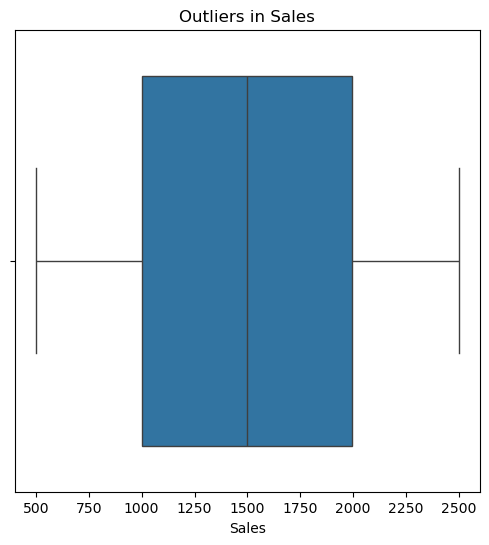

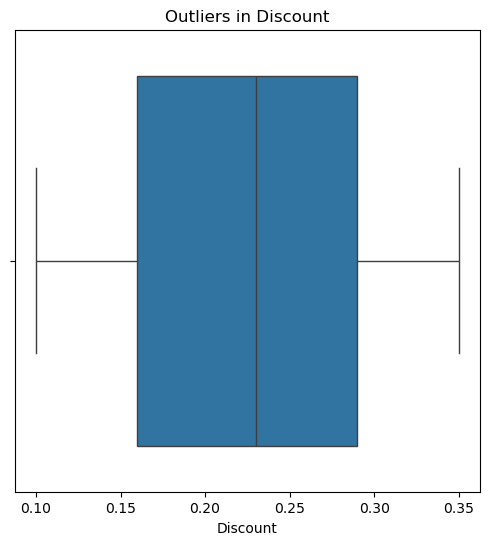

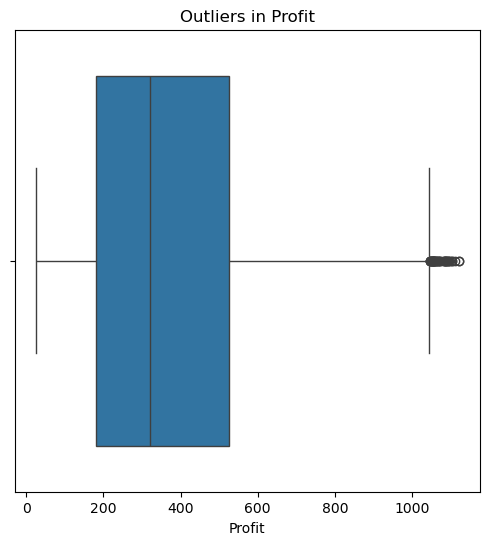

In [12]:
for column in ["Sales", "Discount", "Profit"]:
    plt.figure(figsize=(6,6))
    sns.boxplot(x=df[column])
    plt.title(f"Outliers in {column}")
    plt.show()

The columns Sales and Discount do not contain any outliers. The column Profit does this, which should be questioned. Next, we will look at some statistics and histograms to learn about the distribution of these columns.

In [13]:
df.describe()

,Order Date,Sales,Discount,Profit
count,9994,9994.000000,9994.000000,9994.000000
mean,2017-04-30 05:17:08.056834048,1496.596158,0.226817,374.937082
min,2015-01-03 00:00:00,500.000000,0.100000,25.250000
25%,2016-05-23 00:00:00,1000.000000,0.160000,180.022500
50%,2017-06-26 00:00:00,1498.000000,0.230000,320.780000
75%,2018-05-14 00:00:00,1994.750000,0.290000,525.627500
max,2018-12-30 00:00:00,2500.000000,0.350000,1120.950000
std,NaN,577.559036,0.074636,239.932881


In [14]:
def plot_histogramm_seaborn(df: pd.DataFrame, column: str, bins: int=10):
    """
    Creates a histogramm for a specified column using seaborn.

    Args:
        df (pd.Dataframe): The Dataframe containing the data.
        column (str): The column name to create a histogramm for.
        bins (int, optional): The number of bins in the histogramm. Defaults to 10.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column].dropna(), bins=bins, kde=True, edgecolor="black")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.title(f"Histogramm of {column}")
    plt.show()

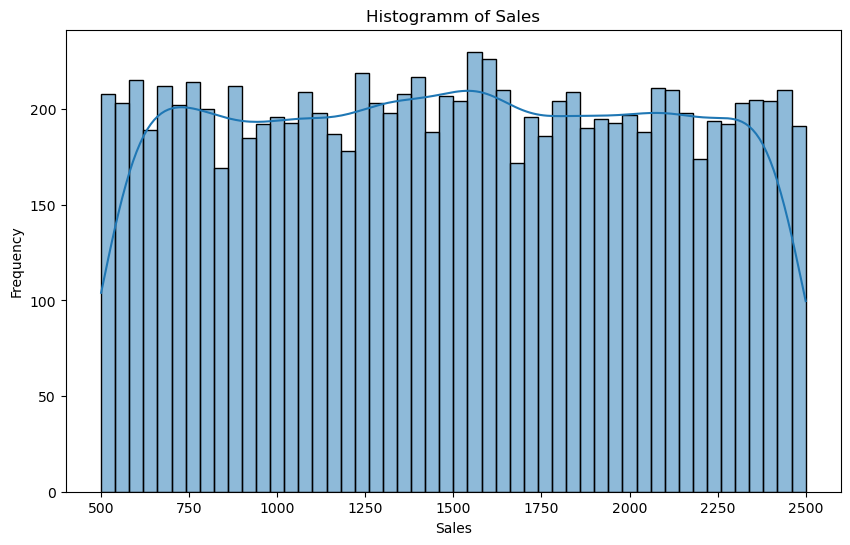

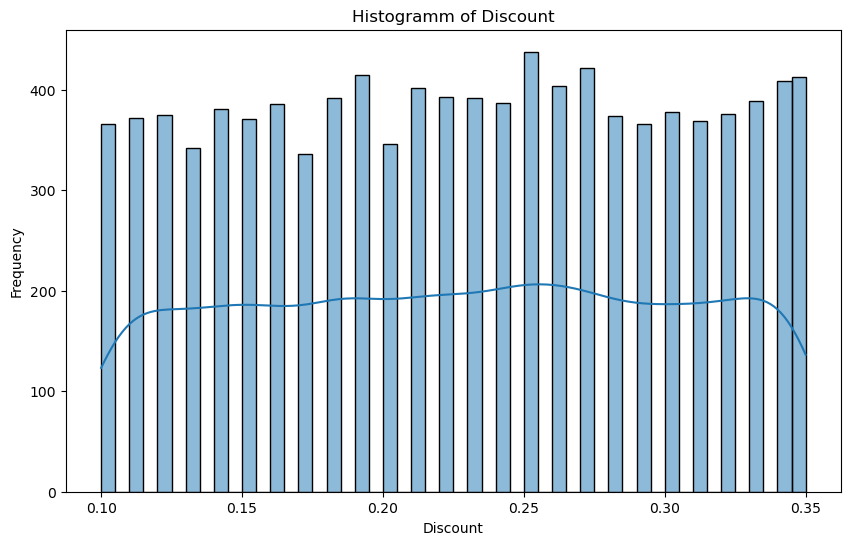

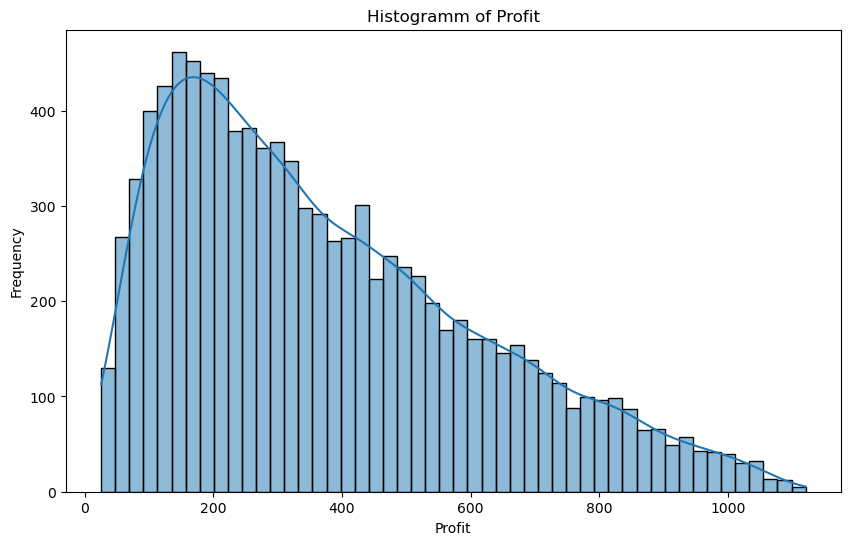

In [15]:
for column in ["Sales", "Discount", "Profit"]:
    plot_histogramm_seaborn(df, column, bins=50)

The columns Sales and Discount appear to be distributed almost uniformly, while the column Profit exhibit considerable skewness.

In [16]:
df["Profit"].skew()

np.float64(0.7673969254823844)

Next, we check the correlation between the three columns.

In [17]:
float_formatter = "{:.3f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

In [18]:
np.corrcoef([df["Sales"], df["Discount"]], df["Profit"])

array([[1.000, -0.006, 0.605],
       [-0.006, 1.000, 0.000],
       [0.605, 0.000, 1.000]])

There appears to be no correlation between (Discount, Profit) and (Sales, Discount). There is a positive correlation between Sales and Profit, which is logical, as more sales often mean more Profit.

Let's create plots to illustrate this.

In [19]:
def plot_correlation(df: pd.DataFrame, x_col: str, y_col: str):
    """
    Creates a scatter plot to visualize the correlation between two columns
    of a pandas DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    x_col (str): Name of the column to be plotted on the x-axis.
    y_col (str): Name of the column to be plotted on the y-axis.

    The function prints the Pearson correlation coefficient and displays
    a scatter plot with an optional regression line.
    """
    
    # Compute correlation
    corr = df[[x_col, y_col]].corr().iloc[0, 1]
    # print(f"Correlation between '{x_col}' and '{y_col}': {corr:.3f}")

    # Create plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=x_col, y=y_col)
    # sns.regplot(data=df, x=x_col, y=y_col, scatter=False, color="red")

    plt.title(f"Correlation between {x_col} and {y_col}: {corr:.3f}")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.tight_layout()
    plt.show()

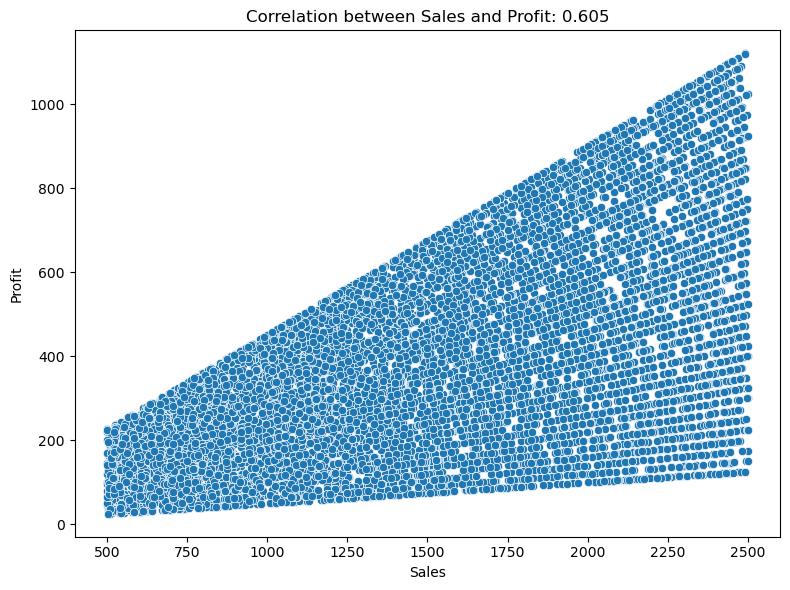

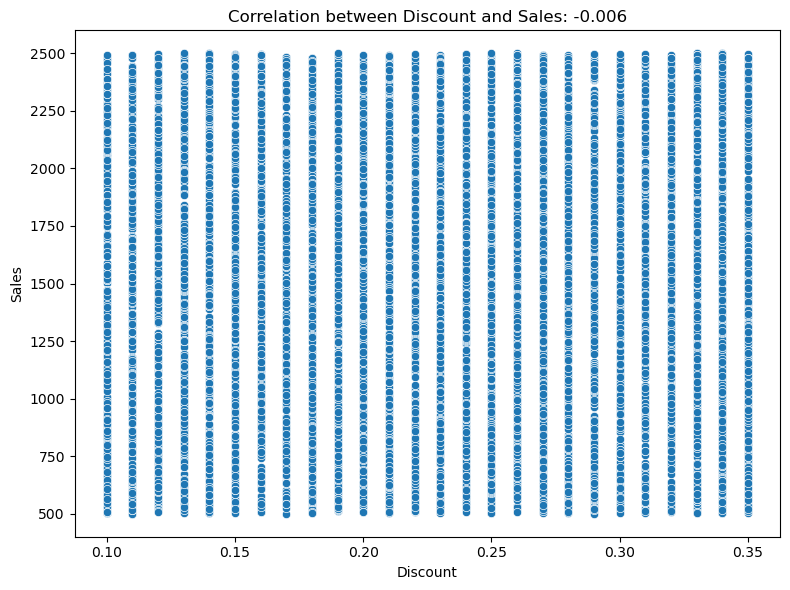

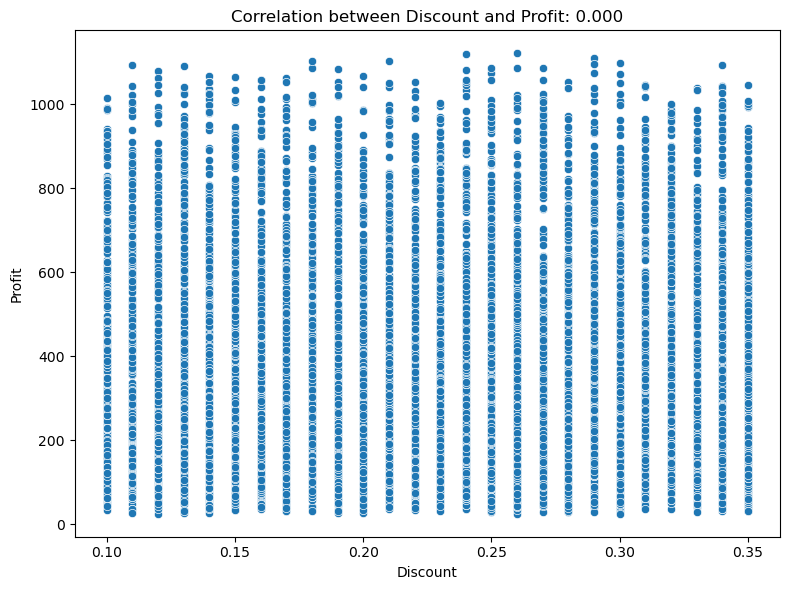

In [20]:
plot_correlation(df, "Sales", "Profit")
plot_correlation(df, "Discount", "Sales")
plot_correlation(df, "Discount", "Profit")

Let's check whether some categories generate more Sales than others.

In [21]:
df.groupby(by="Category")["Sales"].agg(["count", "mean", "std", "min", "max", "sum"])

,count,mean,std,min,max,sum
Category,,,,,,
Bakery,1413,1494.891012,580.833734,501,2500,2112281
Beverages,1400,1489.509286,585.201624,502,2500,2085313
"Eggs, Meat & Fish",1490,1521.745638,572.847848,500,2499,2267401
Food Grains,1398,1513.070100,569.730711,501,2499,2115272
Fruits & Veggies,1418,1481.471791,574.527240,500,2500,2100727
Oil & Masala,1361,1497.753123,585.119233,500,2500,2038442
Snacks,1514,1477.903567,575.020672,500,2500,2237546


No category is more popular than other categories, as the categories are ordered with equal frequency. No category shows significantly more or fewer sales than other categories. 

In [22]:
df.groupby(by="Sub Category")["Sales"].agg(["count", "mean", "std", "min", "max", "sum"])

,count,mean,std,min,max,sum
Sub Category,,,,,,
Atta & Flour,353,1514.586402,567.783008,502,2499,534649
Biscuits,459,1490.376906,602.336288,501,2494,684083
Breads & Buns,502,1479.254980,567.404567,501,2493,742586
Cakes,452,1516.840708,573.917712,504,2500,685612
Chicken,348,1495.681034,585.093612,500,2499,520497
Chocolates,499,1470.737475,576.280632,503,2500,733898
Cookies,520,1477.332692,568.098948,501,2499,768213
Dals & Pulses,343,1525.862974,579.339008,502,2495,523371
Edible Oil & Ghee,451,1481.343681,573.681723,500,2494,668086


Some sub categories have more than double the sales than some other sub categories.

In [23]:
def plot_bar_aggregated(
    df: pd.DataFrame,
    x_col: str,
    y_col: str,
    agg_func=sum,
    title: str = None,
    rotation: int = 0
):
    """
    Creates a bar plot with aggregated values for a categorical x-column.

    Parameters:
    df (pd.DataFrame): Data source.
    x_col (str): Column to display on the x-axis (categorical).
    y_col (str): Column containing numerical values to aggregate.
    agg_func (callable): Aggregation function (e.g., sum, mean, max).
    title (str): Plot title. If None, a default title is generated.
    rotation (int): Rotation angle for x-axis labels.
    """

    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x="Category", y="Sales", data=df, estimator=sum)

    ax.tick_params(axis="x", rotation=45)
    for label in ax.get_xticklabels():
        label.set_ha("right")

    plt.title("Total Sales by Category")
    plt.tight_layout()
    plt.show()

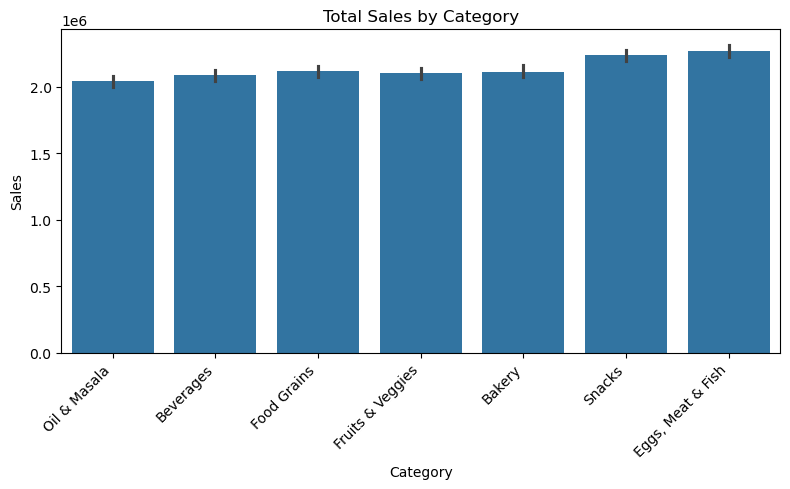

In [24]:
plot_bar_aggregated(df, "Category", "Sales", rotation=45)

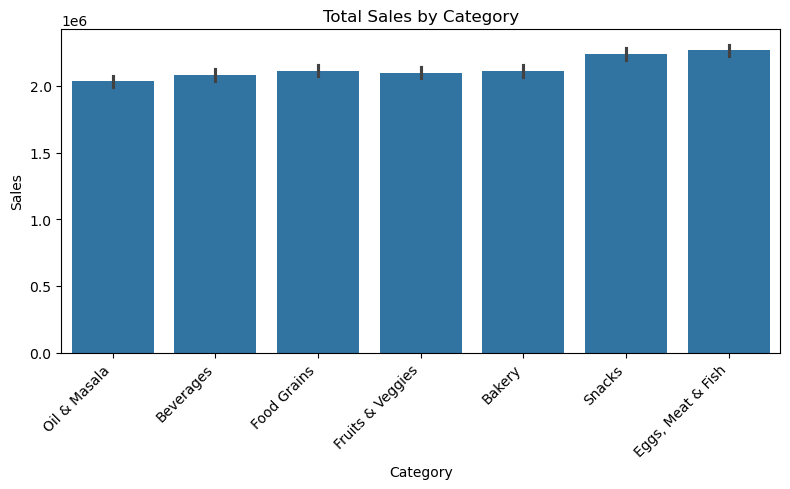

In [25]:
plot_bar_aggregated(df, "Sub Category", "Sales", rotation=45)

Now lets do the Location.

In [26]:
df.groupby(by="Region")["Sales"].agg(["count", "mean", "std", "min", "max", "sum"])

,count,mean,std,min,max,sum
Region,,,,,,
Central,2323,1492.964270,575.764718,501,2500,3468156
East,2848,1491.702247,574.266909,500,2500,4248368
North,1,1254.000000,NaN,1254,1254,1254
South,1619,1507.387894,581.315656,500,2500,2440461
West,3203,1498.202623,580.131737,500,2500,4798743


Only one Order from the North.

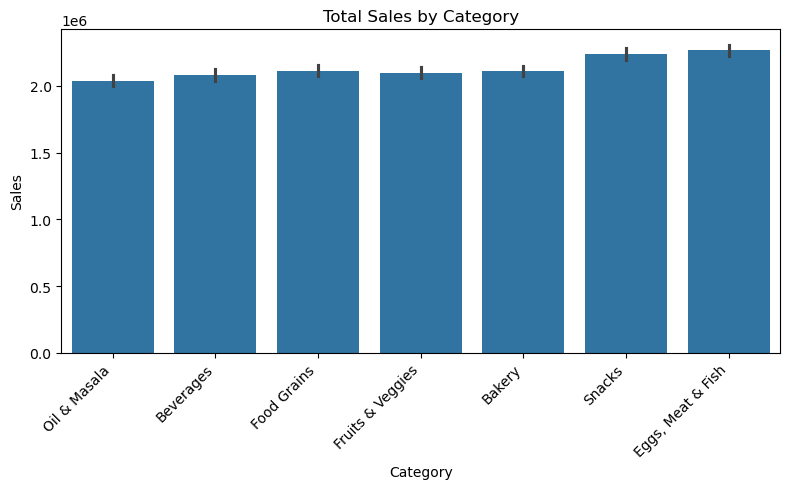

In [27]:
plot_bar_aggregated(df, "Region", "Sales")

Sales by Order Date.

In [28]:
df.groupby(by="Order Date")["Sales"].agg(["count", "mean", "std", "min", "max", "sum"])#.sort_values(by="count", ascending=False)

,count,mean,std,min,max,sum
Order Date,,,,,,
2015-01-03,1,864.000000,NaN,864,864,864
2015-01-04,3,1163.333333,753.770743,698,2033,3490
2015-01-05,1,878.000000,NaN,878,878,878
2015-01-06,9,1558.444444,528.964581,796,2259,14026
2015-01-07,2,1608.000000,463.862048,1280,1936,3216
...,...,...,...,...,...,...
2018-12-26,4,1177.750000,358.665466,741,1579,4711
2018-12-27,2,1787.500000,630.032142,1342,2233,3575
2018-12-28,19,1361.842105,630.468632,633,2394,25875


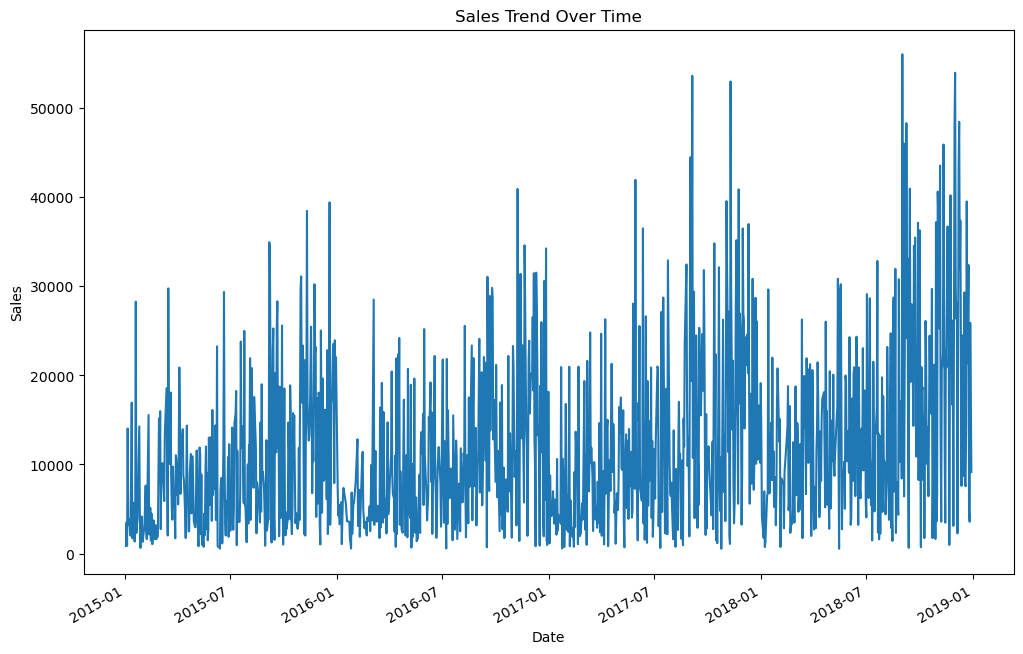

In [29]:
plt.figure(figsize=(12,8))
df.groupby("Order Date")["Sales"].sum().plot()
plt.title("Sales Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

In [30]:
def plot_trend_and_seasonality(df, date_col="Order Date", value_col="Sales", freq=None):
    """
    Decomposes a time series into trend, seasonal, and residual components 
    and plots them.

    Parameters:
    df (pd.DataFrame): Input data.
    date_col (str): Column name containing dates.
    value_col (str): Column name with numeric values.
    freq (str or int): Optional frequency. Examples:
                       'D' (daily), 'W' (weekly), 'M' (monthly), 
                       or integer period for seasonal_decompose.
    """

    # Convert to datetime
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    # Sort by date
    df = df.sort_values(date_col)

    # Set index
    df = df.set_index(date_col)

    # Decomposition (model='additive' can be changed to 'multiplicative')
    decomposition = seasonal_decompose(df[value_col], model='additive', period=freq)

    # Plot
    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(df[value_col], label="Original")
    plt.legend()

    plt.subplot(412)
    plt.plot(decomposition.trend, label="Trend", color="red")
    plt.legend()

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label="Seasonal", color="green")
    plt.legend()

    plt.subplot(414)
    plt.plot(decomposition.resid, label="Residual", color="gray")
    plt.legend()

    plt.tight_layout()
    plt.show()

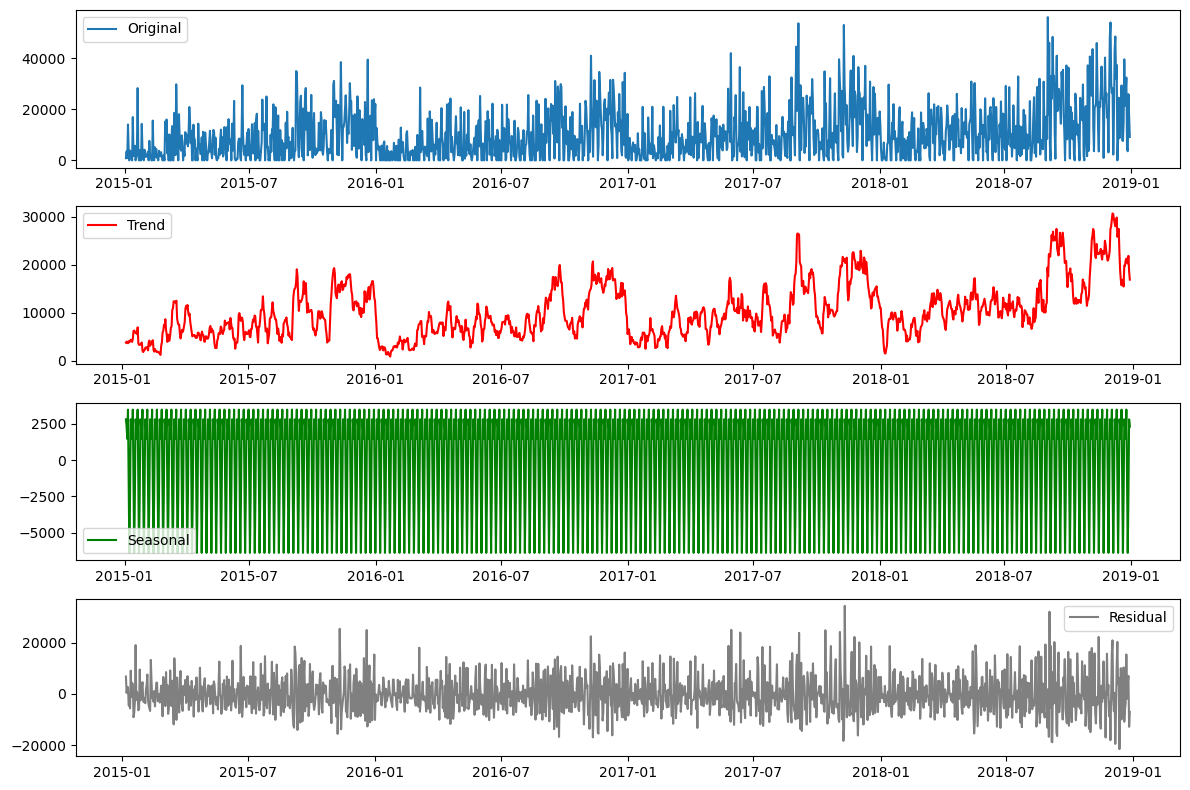

In [31]:
df_daily = df.resample("D", on="Order Date")["Sales"].sum().reset_index()
plot_trend_and_seasonality(df_daily.reset_index(), freq=7)

# Future Work
- Sales by City
- training model for forecasting (regression for sales) or statistical regression using statsmodels
- advanced plots for regression